In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



/Users/areebnadeem/miniforge3/envs/face/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2010-01-01')
df
# The closing price is the raw price, which is just the cash value of the last transacted price before the 
# market closes. The adjusted closing price factors in anything that might affect the stock price after the
# market closes.

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,7.619643,7.520000,7.611786,7.526071,352410800.0,6.425999
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.526021
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.537303
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.433320
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.421426
...,...,...,...,...,...,...
2022-08-16,173.710007,171.660004,172.779999,173.029999,56377100.0,173.029999
2022-08-17,176.149994,172.570007,172.770004,174.550003,79542000.0,174.550003
2022-08-18,174.899994,173.119995,173.750000,174.149994,62290100.0,174.149994


In [3]:
df['Close']

Date
2009-12-31      7.526071
2010-01-04      7.643214
2010-01-05      7.656429
2010-01-06      7.534643
2010-01-07      7.520714
                 ...    
2022-08-16    173.029999
2022-08-17    174.550003
2022-08-18    174.149994
2022-08-19    171.520004
2022-08-22    167.562103
Name: Close, Length: 3182, dtype: float64

Text(0, 0.5, 'Close Price USD $')

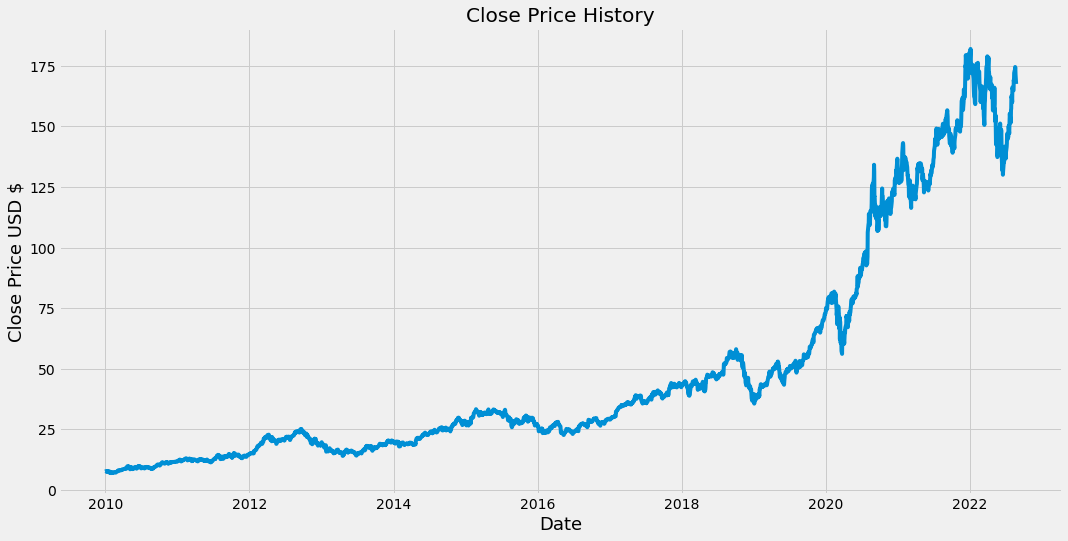

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)

In [5]:
data = df.filter(['Close'])
dataset = data.values # convert to numpy array
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len
dataset

array([[  7.52607107],
       [  7.64321423],
       [  7.65642881],
       ...,
       [174.1499939 ],
       [171.52000427],
       [167.56210327]])

In [6]:
# Scale the data

# Feature scaling is a method used to normalize the range of independent variables or features 
# of data. In data processing, it is also known as data normalization and is generally performed during the data 
# preprocessing step.
# Scaling explanation: https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00380895],
       [0.00447776],
       [0.00455321],
       ...,
       [0.95512445],
       [0.9401089 ],
       [0.91751183]])

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = [] # dependent variables
y_train = [] # independent variables

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    

In [8]:
len(x_train[0])

60

In [9]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [10]:
# Reshape the data because LSTM network expects the input to be 
# in 3D format (num of samples, num of timestamps, num of features)
x_train.shape # current shape


(2486, 60)

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2486, 60, 1)

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False)) # no more LSTM layers
model.add(Dense(25))
model.add(Dense(1))

In [13]:
# optimizer is used to improve loss function
# loss function is used to measure how well model did on training 
model.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2022-08-23 02:52:56.664868: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2486/2486 [==============================] - 24s 9ms/step - loss: 1.9055e-04


In [15]:
# Create testing data set
# Create a new array containing scaled values from index 2425 to 2485
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [16]:
# Convert data to numpy array
x_test = np.array(x_test)


In [17]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test

array([[[0.34016963],
        [0.34208226],
        [0.34092612],
        ...,
        [0.41980086],
        [0.41703182],
        [0.42786536]],

       [[0.34208226],
        [0.34092612],
        [0.33650136],
        ...,
        [0.41703182],
        [0.42786536],
        [0.42453964]],

       [[0.34092612],
        [0.33650136],
        [0.33481711],
        ...,
        [0.42786536],
        [0.42453964],
        [0.42465385]],

       ...,

       [[0.77790604],
        [0.76220531],
        [0.76311882],
        ...,
        [0.94964351],
        [0.94873   ],
        [0.95740824]],

       [[0.76220531],
        [0.76311882],
        [0.7817313 ],
        ...,
        [0.94873   ],
        [0.95740824],
        [0.95512445]],

       [[0.76311882],
        [0.7817313 ],
        [0.81518813],
        ...,
        [0.95740824],
        [0.95512445],
        [0.9401089 ]]])

In [18]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # unscale values

In [19]:
# Get the root mean squared error (RMSE) to check accuracy, lower values indicate better fit
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.8905793633757195

/var/folders/1h/nkc0_l9178z2hxq5xp_4jd840000gn/T/ipykernel_8157/2680842922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


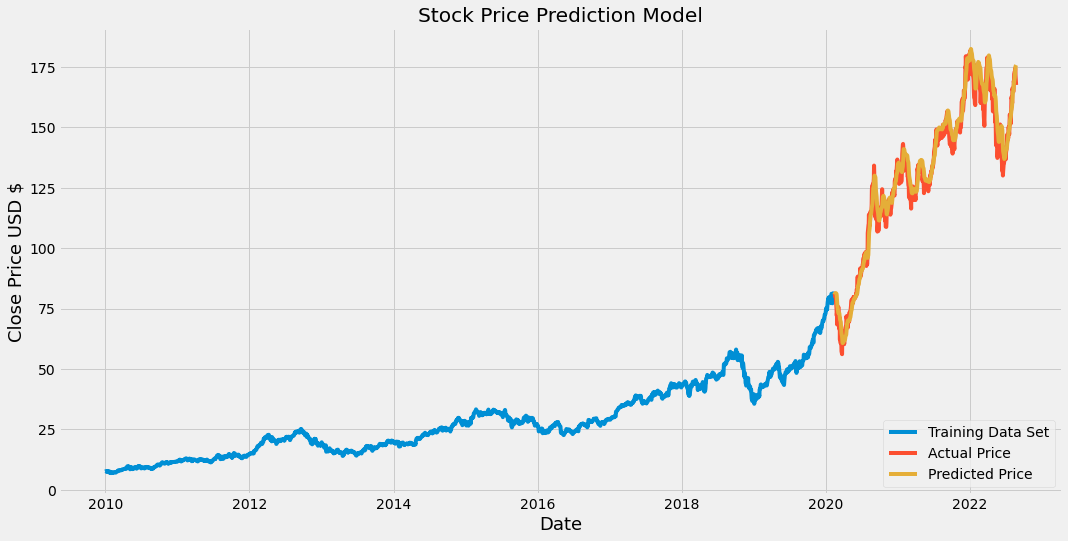

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training Data Set', 'Actual Price', 'Predicted Price'], loc = 'lower right')
plt.show()

In [21]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-02-13,81.217499,80.830391
2020-02-14,81.237503,81.082352
2020-02-18,79.750000,81.307777
2020-02-19,80.904999,81.337921
2020-02-20,80.074997,81.383644
...,...,...
2022-08-16,173.029999,171.769333
2022-08-17,174.550003,173.003006
2022-08-18,174.149994,174.229538


In [22]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-04', end ='2019-12-17')

new_df = apple_quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[68.49165]]


In [23]:
apple_quote2 = web.DataReader('AAPL', data_source = 'yahoo', start = '2019-12-18', end ='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-17    70.102501
2019-12-18    69.934998
Name: Close, dtype: float64
